## Завадання №1
Згенерувати n=2000 точок з суміші розподілів $N(-10;\: (1.2)^2)$, $N(0;\: 4)$, $N(5;\: 25)$. \
$\mu_1=-10$, $\mu_2=0$, $\mu_3=5$ \
$\pi_1=0.3$, $\pi_2=0.5$, $\pi_3=0.2$ \
Застосувати ЕМ - алгоритм для оцінки параметрів. Побудувати графіки залeжності параметрів від $t$ - номеру ітерації. \
Початкове значення: \
$\mu_j^{(0)}\sim U(\min_{i}(x_i);\:\max_i(x_i))$ \
$\sigma_j^{(0)}\sim U\bigg(0;\: \frac{\max(x_i)-\min(x_i)}{6}\bigg)$ \
$\pi_j^{(0)}\sim U(0;\: 1)$

In [45]:
# Підключаємо необхідні бібліотеки
import re
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.stats import norm
from scipy.linalg import eig
from scipy.stats import poisson
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture

In [257]:
# Визначаємо параметри
n_samples = 2000
means = [-10, 0, 5]
std_devs = [np.power(1.2, 2), 2, 5]
weights = [0.3, 0.5, 0.2]

In [258]:
# Генеруємо точки з суміші розподілів
np.random.seed(42)
data = np.hstack([
    np.random.normal(loc=mean, scale=std, size=int(weight * n_samples))
    for mean, std, weight in zip(means, std_devs, weights)
])

In [259]:
# Підгонка моделі сумішіза допомогою EM - алгоритму
gmm = GaussianMixture(n_components=3, random_state=42)
gmm.fit(data.reshape(-1, 1))

GaussianMixture(n_components=3, random_state=42)

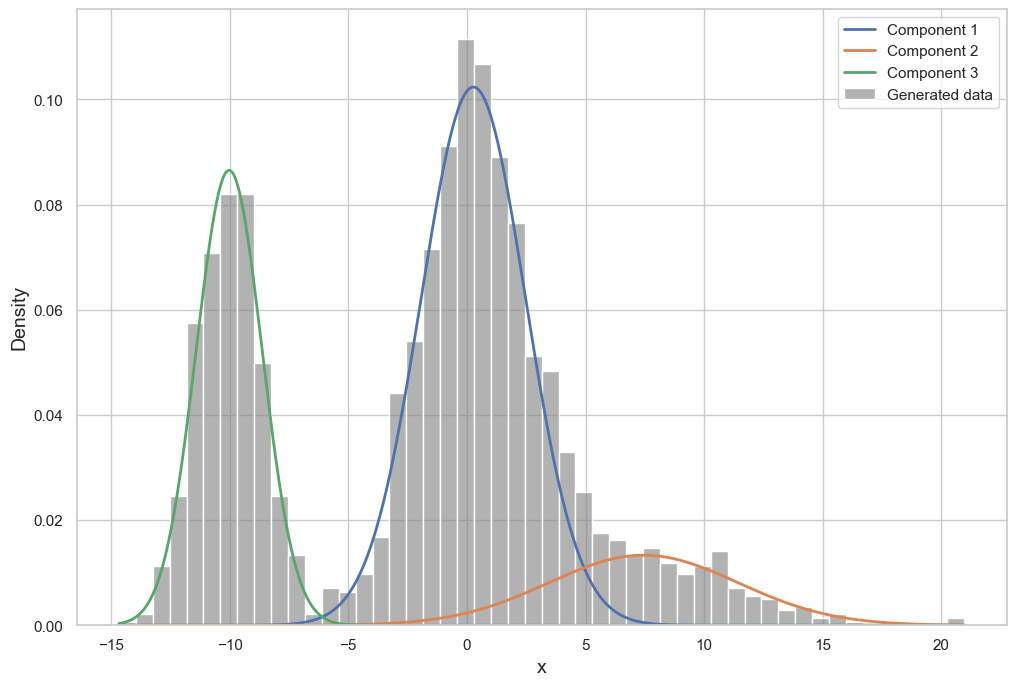

In [260]:
# Генеруємо значення Х для відображення на графіку
x = np.linspace(min(data), max(data), 1000).reshape(-1, 1)

# Візуалізація результатів
sns.set(style='whitegrid')
plt.figure(figsize=(12, 8))
sns.histplot(data, bins=50, kde=False, color='gray', stat='density', label='Generated data', alpha=0.6)

for i in range(3):
    mu = gmm.means_[i, 0]
    sigma = np.sqrt(gmm.covariances_[i, 0])
    plt.plot(x, gmm.weights_[i] * norm.pdf(x, mu, sigma), label=f'Component {i+1}', linewidth=2)

plt.legend()
plt.xlabel('x', fontsize=14)
plt.ylabel('Density', fontsize=14)
plt.show()

## Завдання №2
Згенерувати n=3000 спостережень з суміші трьох розподілів Пуассона: \
$Poiss(1)$, $Poiss(6)$, $Poiss(12)$ \
$\pi_1=0.4$, $\pi_2=0.25$, $\pi_3=0.35$ \
За спостереженими значеннями $x_1,\:...,\:x_n$ за допомогою ЕМ - алгоритму оцінити параметри $\lambda_1$, $\lambda_2$, $\lambda_3$, $\pi_1$, $\pi_2$, $\pi_3$. \
Початкові значення: \
$\lambda_j^{(0)}\sim U(\min_i(x_i);\: \max_i(x_i))$, $j=1,\: 2,\: 3$ \
$\pi_j^{(0)}\sim U(0,\: 1)$, $j=1,\: 2,\: 3$ \
Продемонструвати графіки збіжності $\pi_j^{(t)},\: \lambda_j^{(0)}$ до істинних значень параметрів при $t \rightarrow \infty$.

In [261]:
# Визначаємо параметри
np.random.seed(42) 
n = 3000
true_lambdas = [1, 6, 12]
true_pis = [0.4, 0.25, 0.35]

In [262]:
# Генеруємо точки з суміші розподілів
data = []
for i in range(n):
    component = np.random.choice(3, p=true_pis)
    data.append(np.random.poisson(true_lambdas[component]))
data = np.array(data)

In [263]:
# Ініціалізація параметрів
min_x, max_x = data.min(), data.max()
lambdas = np.random.uniform(min_x, max_x, size=3)   # Ініціалізація λ
pis = np.random.dirichlet([1, 1, 1])                # Ініціалізація π

In [264]:
lambdas_history = [lambdas.copy()]
pis_history = [pis.copy()]

# EM-алгоритм
max_iter = 1000     # Максимальна кількість ітерацій
tol = 1e-6          # Точність для зупинки алгоритму

for iteration in range(max_iter):
    # Обчислення ймовірностей належності до компонент
    responsibilities = np.zeros((n, 3))
    for j in range(3):
        responsibilities[:, j] = pis[j] * poisson.pmf(data, lambdas[j])
    responsibilities /= responsibilities.sum(axis=1, keepdims=True)
    
    # Оновлення параметрів
    N_j = responsibilities.sum(axis=0)
    pis = N_j / n
    lambdas = (responsibilities.T @ data) / N_j

    # Збереження параметрів для візуалізації
    lambdas_history.append(lambdas.copy())
    pis_history.append(pis.copy())

    # Перевірка на збіжність
    if np.linalg.norm(lambdas - lambdas_history[-2]) < tol and np.linalg.norm(pis - pis_history[-2]) < tol:
        break

In [265]:
# Візуалізація результатів
lambdas_history = np.array(lambdas_history)
pis_history = np.array(pis_history)

# Функція побудови графіків
def show_graph(param, x, y):
    plt.figure(figsize=(12, 6))
    for j in range(3):
        plt.plot(x[:, j], label=rf'$\{param}_{j+1}$ (оцінка)', color=f'C{j}')
        plt.axhline(y=y[j], color='red', linestyle='--', label=rf'$\{param}$ (істинне)' if j == 0 else None)
    plt.title(rf'Збіжність параметрів $\{param}$')
    plt.xlabel('Ітерація')
    plt.ylabel(rf'$\{param}$')
    plt.legend()
    plt.grid()
    plt.show()

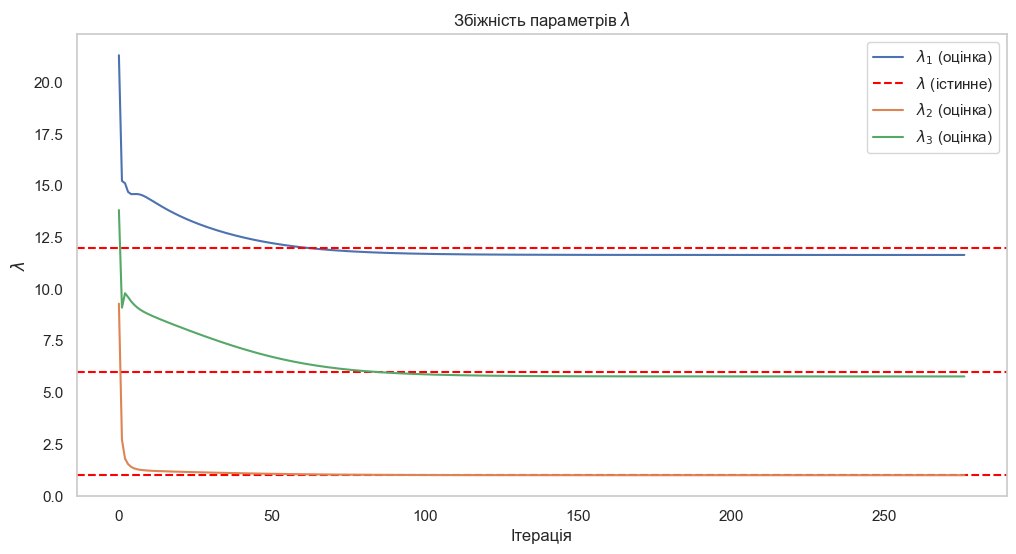

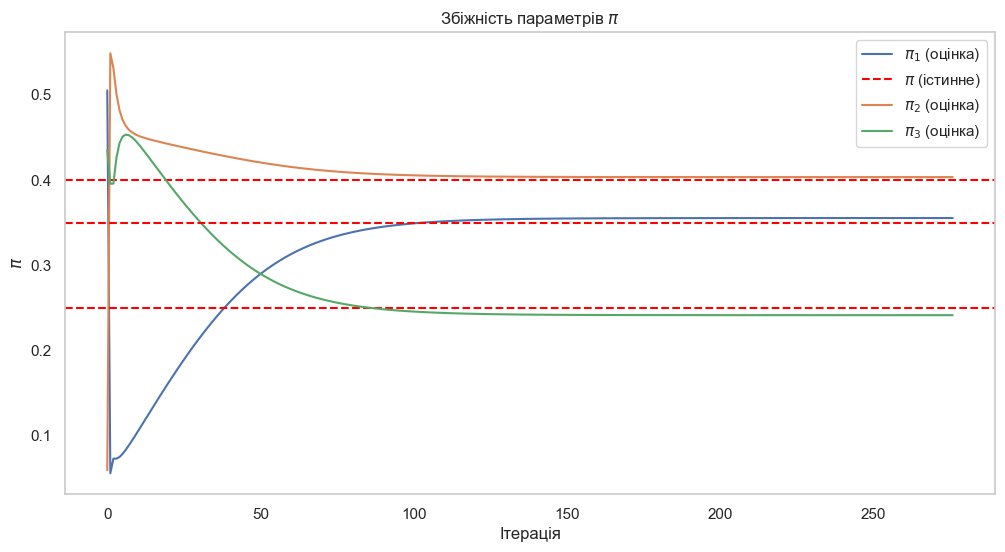

Оцінені параметри:
λ = 11.657, π = 0.355
λ = 1.003, π = 0.403
λ = 5.780, π = 0.241

Істинні значення:
λ = 1.000, π = 0.400
λ = 6.000, π = 0.250
λ = 12.000, π = 0.350


In [266]:
# Побудова графіку збіжності λ
show_graph('lambda', lambdas_history, true_lambdas)

# Побудова графіку збіжності π
show_graph('pi', pis_history, true_pis)

print('Оцінені параметри:')
for j in range(3):
    print(f'λ = {lambdas[j]:.3f}, π = {pis[j]:.3f}')

print('\nІстинні значення:')
for j in range(3):
    print(f'λ = {true_lambdas[j]:.3f}, π = {true_pis[j]:.3f}')

## Завдання №3

In [267]:
# Функція обробки тексту
def text_processing(filename, spaces=True):
    with open(filename, 'r', encoding='UTF-8') as file:
        data = file.read().lower()                  # Приводимо текст до нижнього регістру
    
    # Залишаємо лише літери українського алфавіту та пробіли
    processed_text = re.sub(r'[^а-яіїєґ]', '', data)
    return processed_text if spaces else processed_text.replace(' ', '')

In [268]:
filename = 'data/input_text.txt'

# Обробка тексту
text = text_processing(filename)
symbol_dict = {symbol: idx for idx, symbol in enumerate(sorted(set(text)))}

In [269]:
# Ініціалізація матриць HMM
def initialize_matrices(M, N):
    A = np.full((N, N), 1 / N)                      # Початкова ймовірність переходу
    B = np.random.dirichlet(np.ones(M), size=N)     # Матриця спостережень
    pi = np.full(N, 1 / N)                          # Початковий розподіл станів
    return A, B, pi

# Алгоритм Баума-Велча
def baum_welch_algorithm(text, A, B, pi, symbol_dict, max_iter=100):
    for _ in range(max_iter):
        alpha, beta, gamma, xi = forward_backward(text, A, B, pi, symbol_dict)
        A = np.sum(xi, axis=0) / np.sum(gamma[:-1], axis=0, keepdims=True)
        A /= A.sum(axis=1, keepdims=True)
        B = np.zeros_like(B)
        for t, symbol in enumerate(text):
            B[:, symbol_dict[symbol]] += gamma[t]
        B /= np.sum(B, axis=1, keepdims=True)
        pi = gamma[0]
    return A, B

# Функція прямого та зворотного проходу
def forward_backward(text, A, B, pi, symbol_dict):
    L, N = len(text), len(pi)
    alpha, beta = np.zeros((L, N)), np.zeros((L, N))
    scales = np.zeros(L)
    xi = np.zeros((L - 1, N, N))

    alpha[0] = pi * B[:, symbol_dict[text[0]]]
    scales[0] = alpha[0].sum()
    alpha[0] /= scales[0]

    for t in range(1, L):
        alpha[t] = (alpha[t - 1] @ A) * B[:, symbol_dict[text[t]]]
        scales[t] = alpha[t].sum()
        alpha[t] /= scales[t]

    beta[-1] = 1 / scales[-1]
    for t in range(L - 2, -1, -1):
        beta[t] = (A * B[:, symbol_dict[text[t + 1]]]) @ beta[t + 1]
        beta[t] /= scales[t]

    gamma = (alpha * beta) / (alpha * beta).sum(axis=1, keepdims=True)
    for t in range(L - 1):
        xi[t] = np.outer(alpha[t], beta[t + 1] * B[:, symbol_dict[text[t + 1]]]) * A
        xi[t] /= xi[t].sum()
    
    return alpha, beta, gamma, xi

# Функція класифікації символів за ймовірністю
def classify_symbols(B, symbol_dict):
    return {symbol: np.argmax(B[:, idx]) + 1 for symbol, idx in symbol_dict.items()}

#### Розділяємо знаки алфавiту на N = 2 класи

In [270]:
# Ініціалізація параметрів
N, M = 2, len(symbol_dict)
A, B, pi = initialize_matrices(M, N)

# Навчання HMM
A, B = baum_welch_algorithm(text, A, B, pi, symbol_dict)

# Виведення матриць А та В
print(f'Matrix A:\n{A}\n')
print(f'Matrix B:\n{B}\n')

Matrix A:
[[0.21322688 0.78677312]
 [0.92629314 0.07370686]]

Matrix B:
[[3.80054496e-021 3.63500998e-002 1.06641522e-001 3.72260051e-002
  5.89484751e-002 6.09669924e-053 1.43210634e-002 3.75924009e-002
  6.28056739e-050 2.44814869e-002 6.78894889e-002 7.83059982e-002
  5.49193074e-002 1.02043051e-001 6.17943607e-041 4.69146357e-002
  7.81308170e-002 7.09281156e-002 8.12131670e-002 2.63363325e-025
  8.57839827e-004 2.34181058e-002 1.06422581e-002 2.68903148e-002
  1.27523976e-002 9.76635212e-003 2.87561570e-027 5.58082037e-003
  2.95033846e-009 7.60811156e-003 5.11995456e-004 6.02237212e-003
  4.37953010e-005]
 [1.99574196e-001 1.09078256e-020 4.58329618e-008 9.94056574e-010
  1.92778226e-016 1.01805513e-001 1.88978117e-013 6.28384532e-003
  1.57657532e-001 1.09032940e-007 9.86831256e-004 2.25832244e-065
  8.75129568e-026 5.89154153e-050 2.11186992e-001 1.97830462e-003
  4.79454875e-050 6.88267654e-003 1.47201381e-003 7.77504350e-002
  7.81106754e-005 2.61468651e-003 4.06248801e-034 1

#### Перевіряємо стохастичність матриць А та В

In [271]:
print(f'Sum A \n{np.sum(A, axis=1)}\n')
print(f'Sum B \n{np.sum(B, axis=1)}\n')

Sum A 
[1. 1.]

Sum B 
[1. 1.]



#### Виводимо результат класифікації

In [272]:
classification = classify_symbols(B, symbol_dict)
for symbol in sorted(classification):
    print(f"'{symbol}' -> {classification[symbol]}")

state_symbols = {state: [symbol for symbol, s in classification.items() if s == state] for state in range(1, N + 1)}
for state, symbols in state_symbols.items():
    print(f'The state {state} contains symbols: {symbols}')

'а' -> 2
'б' -> 1
'в' -> 1
'г' -> 1
'д' -> 1
'е' -> 2
'ж' -> 1
'з' -> 1
'и' -> 2
'й' -> 1
'к' -> 1
'л' -> 1
'м' -> 1
'н' -> 1
'о' -> 2
'п' -> 1
'р' -> 1
'с' -> 1
'т' -> 1
'у' -> 2
'ф' -> 1
'х' -> 1
'ц' -> 1
'ч' -> 1
'ш' -> 1
'щ' -> 1
'ь' -> 2
'ю' -> 2
'я' -> 2
'є' -> 1
'і' -> 2
'ї' -> 1
'ґ' -> 1
The state 1 contains symbols: ['б', 'в', 'г', 'д', 'ж', 'з', 'й', 'к', 'л', 'м', 'н', 'п', 'р', 'с', 'т', 'ф', 'х', 'ц', 'ч', 'ш', 'щ', 'є', 'ї', 'ґ']
The state 2 contains symbols: ['а', 'е', 'и', 'о', 'у', 'ь', 'ю', 'я', 'і']


#### Розділяємо знаки алфавiту на N = 3 класи

In [273]:
# Ініціалізація параметрів
N, M = 3, len(symbol_dict)
A, B, pi = initialize_matrices(M, N)

# Навчання HMM
A, B = baum_welch_algorithm(text, A, B, pi, symbol_dict)

# Виведення матриць А та В
print(f'Matrix A:\n{A}\n')
print(f'Matrix B:\n{B}\n')

Matrix A:
[[3.60901202e-15 4.27564846e-01 5.72435154e-01]
 [9.99993567e-01 6.43082246e-06 2.53655688e-09]
 [1.34705481e-01 5.61815006e-01 3.03479513e-01]]

Matrix B:
[[2.08362645e-001 3.76682726e-061 1.46562400e-050 2.14009278e-068
  4.02251283e-054 1.12872884e-001 7.05010321e-081 3.97838021e-020
  1.75528110e-001 6.38155758e-082 3.81775317e-024 1.58546286e-063
  3.05018276e-104 1.57706140e-066 2.11561077e-001 1.23003050e-036
  2.50970375e-087 5.28067747e-036 2.02614041e-029 7.78388053e-002
  2.50885488e-060 1.03035168e-039 4.08357777e-049 8.36230483e-121
  1.25574206e-066 1.18874537e-006 5.03970175e-002 7.39795613e-003
  3.57801811e-002 1.36027014e-018 1.20260135e-001 6.77563551e-018
  0.00000000e+000]
 [1.32639169e-042 4.01981947e-002 7.94378541e-002 3.63437897e-002
  5.48657688e-002 7.24144345e-010 1.40626830e-002 2.43417843e-002
  1.42143146e-005 1.22403691e-017 7.43380290e-002 1.19318317e-001
  4.67766077e-002 1.28191674e-001 8.62214549e-066 5.18921730e-002
  9.11625372e-002 4.699

#### Перевіряємо стохастичність матриць А та В

In [274]:
print(f'Sum A \n{np.sum(A, axis=1)}\n')
print(f'Sum B \n{np.sum(B, axis=1)}\n')

Sum A 
[1. 1. 1.]

Sum B 
[1. 1. 1.]



#### Виводимо результат класифікації

In [275]:
classification = classify_symbols(B, symbol_dict)
for symbol in sorted(classification):
    print(f"'{symbol}' -> {classification[symbol]}")

state_symbols = {state: [symbol for symbol, s in classification.items() if s == state] for state in range(1, N + 1)}
for state, symbols in state_symbols.items():
    print(f'The state {state} contains symbols: {symbols}')

'а' -> 1
'б' -> 2
'в' -> 3
'г' -> 2
'д' -> 2
'е' -> 1
'ж' -> 2
'з' -> 3
'и' -> 1
'й' -> 3
'к' -> 2
'л' -> 2
'м' -> 3
'н' -> 2
'о' -> 1
'п' -> 2
'р' -> 2
'с' -> 3
'т' -> 2
'у' -> 1
'ф' -> 3
'х' -> 3
'ц' -> 2
'ч' -> 2
'ш' -> 2
'щ' -> 2
'ь' -> 1
'ю' -> 3
'я' -> 1
'є' -> 3
'і' -> 1
'ї' -> 3
'ґ' -> 2
The state 1 contains symbols: ['а', 'е', 'и', 'о', 'у', 'ь', 'я', 'і']
The state 2 contains symbols: ['б', 'г', 'д', 'ж', 'к', 'л', 'н', 'п', 'р', 'т', 'ц', 'ч', 'ш', 'щ', 'ґ']
The state 3 contains symbols: ['в', 'з', 'й', 'м', 'с', 'ф', 'х', 'ю', 'є', 'ї']


#### Розділяємо знаки алфавiту на N = 4 класи

In [276]:
# Ініціалізація параметрів
N, M = 4, len(symbol_dict)
A, B, pi = initialize_matrices(M, N)

# Навчання HMM
A, B = baum_welch_algorithm(text, A, B, pi, symbol_dict)

# Виведення матриць А та В
print(f'Matrix A:\n{A}\n')
print(f'Matrix B:\n{B}\n')

Matrix A:
[[5.57331937e-06 3.46047019e-01 6.53947407e-01 9.65002136e-15]
 [3.43396628e-01 4.74007205e-02 1.11717145e-38 6.09202651e-01]
 [3.79298783e-01 1.01013593e-01 5.79845512e-17 5.19687624e-01]
 [3.65355420e-01 3.95753882e-01 1.63636563e-01 7.52541352e-02]]

Matrix B:
[[3.25712185e-043 3.80205020e-002 4.43641152e-002 1.64020760e-002
  4.60908077e-002 5.69931186e-007 1.64388968e-002 1.84923728e-002
  3.25285893e-032 8.25452833e-031 8.06783299e-002 1.49210490e-001
  3.23563825e-002 1.50919852e-001 3.81711848e-077 4.58011322e-002
  9.74384595e-002 4.71752279e-002 1.22026929e-001 2.25717776e-044
  5.16105442e-004 7.48025063e-003 2.05804432e-002 3.32887280e-002
  1.32492478e-002 1.94690820e-002 6.52207077e-041 1.74418132e-040
  3.94086972e-045 5.73140678e-037 4.06247942e-030 3.05621682e-039
  7.16790965e-014]
 [2.07938196e-001 4.96618508e-018 3.35192406e-004 9.15033822e-015
  2.01862911e-011 7.87134388e-003 1.30229503e-012 1.39170385e-002
  4.11104816e-003 5.00824335e-005 4.02193958e-0

#### Перевіряємо стохастичність матриць А та В

In [277]:
print(f'Sum A \n{np.sum(A, axis=1)}\n')
print(f'Sum B \n{np.sum(B, axis=1)}\n')

Sum A 
[1. 1. 1. 1.]

Sum B 
[1. 1. 1. 1.]



#### Виводимо результат класифікації

In [278]:
classification = classify_symbols(B, symbol_dict)
for symbol in sorted(classification):
    print(f"'{symbol}' -> {classification[symbol]}")

state_symbols = {state: [symbol for symbol, s in classification.items() if s == state] for state in range(1, N + 1)}
for state, symbols in state_symbols.items():
    print(f'The state {state} contains symbols: {symbols}')

'а' -> 2
'б' -> 1
'в' -> 4
'г' -> 4
'д' -> 4
'е' -> 3
'ж' -> 1
'з' -> 4
'и' -> 3
'й' -> 4
'к' -> 1
'л' -> 1
'м' -> 4
'н' -> 1
'о' -> 2
'п' -> 4
'р' -> 1
'с' -> 4
'т' -> 1
'у' -> 2
'ф' -> 4
'х' -> 4
'ц' -> 1
'ч' -> 1
'ш' -> 1
'щ' -> 1
'ь' -> 3
'ю' -> 2
'я' -> 2
'є' -> 4
'і' -> 2
'ї' -> 4
'ґ' -> 4
The state 1 contains symbols: ['б', 'ж', 'к', 'л', 'н', 'р', 'т', 'ц', 'ч', 'ш', 'щ']
The state 2 contains symbols: ['а', 'о', 'у', 'ю', 'я', 'і']
The state 3 contains symbols: ['е', 'и', 'ь']
The state 4 contains symbols: ['в', 'г', 'д', 'з', 'й', 'м', 'п', 'с', 'ф', 'х', 'є', 'ї', 'ґ']


### Завадання №4

In [ ]:
alphabet = 'абвгґдеєжзиіїйклмнопрстуфхцчшщьюя '
alphabet_map = {letter: idx for idx, letter in enumerate(alphabet)}

In [3]:
def generate_matrix(raw_data_path, alphabet_map):
    # Функція генерує матрицю для заданого тексту
    alphabet_len = len(alphabet_map)
    matrix = np.zeros((alphabet_len, alphabet_len), dtype=np.uint)

    with open(raw_data_path, 'r', encoding='utf-8') as file:
        first_symbol = None
        for line in file:
            for current_el in line.lower():
                if current_el in alphabet_map:
                    if first_symbol is None:
                        first_symbol = current_el
                    else:
                        matrix[alphabet_map[first_symbol], alphabet_map[current_el]] += 1
                        first_symbol = current_el

    matrix += 5
    row_sums = matrix.sum(axis=1)
    result_matrix = matrix / row_sums[:, np.newaxis]

    return result_matrix

In [4]:
def generate_transposition(alphabet_len):
    # Функція генерує перестановковий шифр
    values = np.arange(alphabet_len)
    np.random.shuffle(values)
    return values

def encrypt_text(filepath, cipher, alphabet_map, text_len=None):
    # Функція шифрує текст 
    alphabet_map_idx = {val: i for i, val in enumerate(alphabet_map)}
    real_states = []
    encoded_states = []

    with open(filepath, 'r', encoding='utf-8') as file:
        for line in file:
            lowercase_line = line.lower()
            for i in range(len(line)):
                if lowercase_line[i] in alphabet_map:
                    real_idx = alphabet_map_idx[lowercase_line[i]]
                    encoded_idx = cipher[real_idx]
                    real_states.append(real_idx)
                    encoded_states.append(encoded_idx)
                if text_len is not None and len(encoded_states) >= text_len:
                    return np.array(real_states), np.array(encoded_states)

    return np.array(real_states), np.array(encoded_states)

def states_to_string(states, alphabet):
    # Функція конвертує послідовність індексів у текст
    return ''.join(alphabet[state] for state in states)

Для проведення навчання обераємо текст з файлу input_text.txt. 

In [5]:
with open('data/input_text.txt', 'r', encoding='utf-8') as file:
    contents = file.read()
    print(f'Кількість символів у файлі: {len(contents.replace('\n', ''))}')

Кількість символів у файлі: 51381


In [6]:
matrix = generate_matrix('data/input_text.txt', alphabet_map)

Далі можемо визначити $\mu$, A та B.

In [7]:
# HMM initialization
w, vl = eig(matrix, left=True, right=False)
mu = vl[:, 0]
mu /= np.sum(mu)

alphabet_len = len(alphabet)
A = np.copy(matrix)
B = np.ones((alphabet_len, alphabet_len)) / alphabet_len
noise = np.random.dirichlet(np.ones(alphabet_len), size=alphabet_len)
B += noise * 0.02
B /= np.sum(B, axis=1)

Переглянемо, що у нас вийшло.

In [8]:
print(f'μ\n{mu}')

μ
[0.06920915+0.j 0.01831471+0.j 0.04770979+0.j 0.01868116+0.j
 0.00313188+0.j 0.0277655 +0.j 0.03682996+0.j 0.0067398 +0.j
 0.00910248+0.j 0.02091555+0.j 0.05532722+0.j 0.04607884+0.j
 0.00609887+0.j 0.01335134+0.j 0.03183136+0.j 0.0358596 +0.j
 0.02606251+0.j 0.04578738+0.j 0.07305809+0.j 0.02338803+0.j
 0.03578682+0.j 0.03505437+0.j 0.03756338+0.j 0.02886281+0.j
 0.00349817+0.j 0.01377254+0.j 0.00756408+0.j 0.01435881+0.j
 0.00859   +0.j 0.00719777+0.j 0.01807669+0.j 0.00891926+0.j
 0.01761861+0.j 0.14789347+0.j]


In [9]:
print(f'A:\n{A}')

A:
[[0.00344006 0.01640646 0.08070918 ... 0.02116962 0.00211696 0.27520508]
 [0.098      0.005      0.007      ... 0.007      0.005      0.044     ]
 [0.13627639 0.00422265 0.00422265 ... 0.00191939 0.00729367 0.18925144]
 ...
 [0.01437372 0.02874743 0.02669405 ... 0.02669405 0.01232033 0.25051335]
 [0.00519751 0.00727651 0.04469854 ... 0.01039501 0.00831601 0.31081081]
 [0.0225387  0.04421053 0.10811146 ... 0.00074303 0.01919505 0.00928793]]


In [10]:
print(f'B:\n{B}')

B:
[[0.02915977 0.0309179  0.02974618 ... 0.02896443 0.02888161 0.03089269]
 [0.0307725  0.02978482 0.02904388 ... 0.02928479 0.02892237 0.02976652]
 [0.02888559 0.03166136 0.02979983 ... 0.02890951 0.02885589 0.02949481]
 ...
 [0.03179589 0.0290419  0.02953311 ... 0.02913678 0.02929023 0.02892259]
 [0.03098309 0.02895476 0.03013403 ... 0.02889806 0.02983243 0.03025015]
 [0.02993097 0.02975219 0.02942406 ... 0.02946552 0.02936821 0.02960785]]


Тепер можемо перевірити матриці А та В на стохастичність.

In [11]:
print(f'Sum A \n{np.sum(A, axis=1)}\n')
print(f'Sum B \n{np.sum(B, axis=1)}\n')

Sum A 
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]

Sum B 
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]



Як бачимо, наші матриці стохастичні. \
Тепер можемо зашифрувати навчальний текст та перевірити як працює алгоритм. \
Почнемо з того, що створимо відповідність для перестановочного шифру.

In [12]:
transposition = generate_transposition(len(alphabet))
transposition

array([ 5,  2, 28, 32, 19, 15, 26,  7, 14,  8,  0, 23, 27, 21, 11, 16, 30,
       13,  1,  3, 17, 33, 20, 31, 29,  9, 22, 18, 24, 25, 12, 10,  4,  6])

In [56]:
real_states, encoded_states = encrypt_text('data/input_text.txt', transposition, alphabet, 1000)

Тепер можем перейти до того, щоб навчати нашу модель. 

In [ ]:
# Ця функція виконує оцінку матриці B, додаючи випадковий шум, щоб зробити оцінку більш варіативною.
def reestimate_B():
    noise = np.random.dirichlet(np.ones(alphabet_len), size=alphabet_len) * 0.07
    B_est = (np.ones((alphabet_len, alphabet_len)) / alphabet_len) + noise
    B_est /= B_est.sum(axis=1, keepdims=True)

    return B_est

Навчаємо нашу модель на 500 ітераціях

In [57]:
from HMM import HHM_Algorithm
hmm_estimator = HHM_Algorithm(mu=mu, A=A, B=reestimate_B(), random_state=42, verbose=None)
stats_p = hmm_estimator.fit(encoded_states, max_iter=500, tol=1e-5, reestimate=False)

Цей графік відображає, як покращується логарифмічна ймовірність з часом. 
Чим вона більше, тим краще ми отримаємо модель.

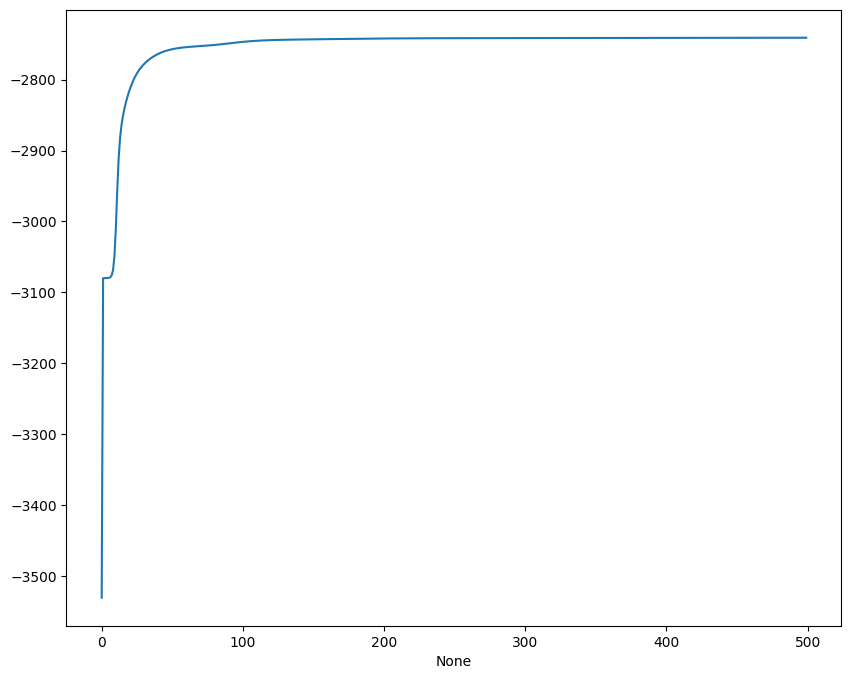

In [58]:
stats_p = pd.Series(stats_p)
plt.figure(figsize=(10, 8))
sns.lineplot(x=stats_p.index, y=stats_p.values)
plt.show()

Порівнюємо отриманий шифр та згенерований.

In [40]:
correspondence = np.argmax(hmm_estimator.emissionprob_, axis=1)
print(f'Received code:\n{correspondence}')
print(f'Generated code:\n{transposition}')

Received code:
[ 5  2 28 32 30 15 26 28 14  8  0 23 27 21 11 16 30 13  1  3 17 33 20 31
  6  9 22  8 24 25 12 10  4  6]
Generated code:
[ 5  2 28 32 19 15 26  7 14  8  0 23 27 21 11 16 30 13  1  3 17 33 20 31
 29  9 22 18 24 25 12 10  4  6]


Давайте підрахуємо кількість символів, які співпадають.

In [39]:
print(f'Accuracy: {np.sum(transposition == correspondence)} symbols')

Accuracy: 30 symbols


Бачимо, що з 34 символів нашого алфавіту лише 4 символи не були знайдені коректно. \
Тепер переглянемо розшифрований текст та початковий, щоб побачити наскільки вони відрізняються.

In [27]:
found_states = hmm_estimator.viterbi(encoded_states)

In [42]:
print(f'Decrypted text:\n{states_to_string(found_states, alphabet)}')
print(f'General data:\n{states_to_string(real_states, alphabet)}')

Decrypted text:
иій би рочказати і про русалок що гарної днини виходять з води на берем щобспівати пісень вигадують байки і политви про потопельників які по заході сонцякушать бліде тіло своє на каменях в рінці всякі злі духи заповнюють скелі лісипровалля хати й загороди та нигають на христи нина аго на маржину щоб зробити їґшкоду не раз прокинувшись улоні серем ворогої тиші він тремтів сповнений жахомвесь світ був як качка повна нудес таєґнина цікава й страшнатепер він вже мав оговячки  його посилали пасти корови гнав в лій своїхговталю та голубалю і коли вони потопали в хвилях лісових трав та полодих смеренокі вже звідти обзивались до нього як зпід води тугливим дзвоном своїх дзвінків вінцідав десь на узбінні гори виймав денцівку сопічку і вигравав немудрі пісні якихнавнився од старших однак та мучика не вдовольняла його з досадою кидав денцівку іслухав інших мелодій що жили в ньому не сні і немловимізнизу підіймавсь до івана і затоплював гори глухий гомін ріки а в нього капав однасу

Зараз можемо протестувати нашу модель на більшій кількості символів. Для цього візьмемо 50 тисяч символів.

In [46]:
real_states, encoded_states = encrypt_text('data/input_text.txt', transposition, alphabet, 50000)

Навчаємо модель.

In [47]:
from HMM import HHM_Algorithm
hmm_estimator = HHM_Algorithm(mu=mu, A=A, B=reestimate_B(), random_state=42, verbose=None)
stats_p = hmm_estimator.fit(encoded_states, max_iter=500, tol=1e-5, reestimate=False)

d:\Projects\MarkovModel\HMM.py:92: ComplexWarning: Casting complex values to real discards the imaginary part
  alphas[t] = self.startprob_


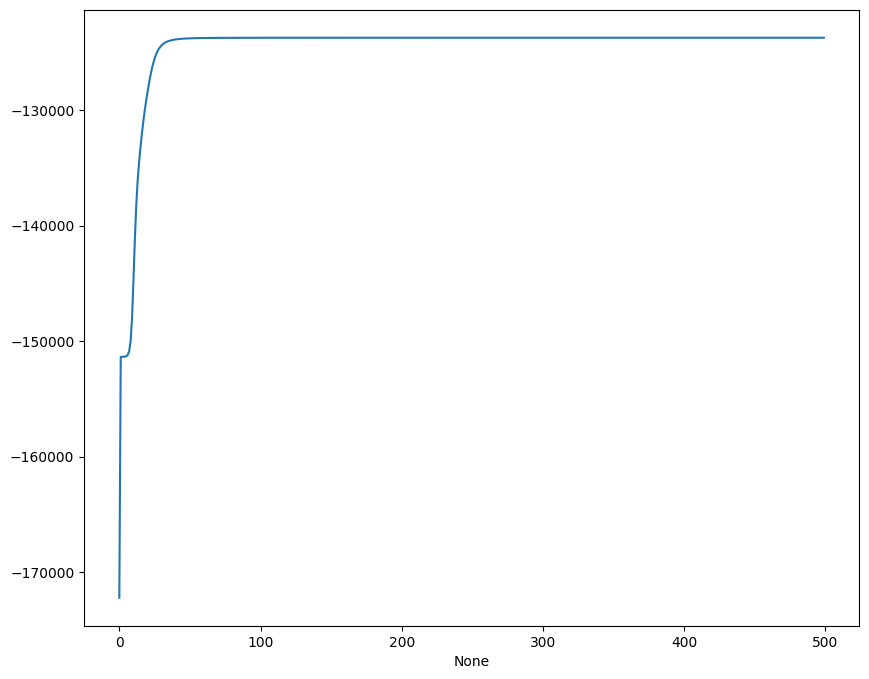

In [53]:
stats_p = pd.Series(stats_p)
plt.figure(figsize=(10, 8))
sns.lineplot(x=stats_p.index, y=stats_p.values)
plt.show()

Порівнюємо отриманий шифр та згенерований.

In [49]:
correspondence = np.argmax(hmm_estimator.emissionprob_, axis=1)
print(f'Received code:\n{correspondence}')
print(f'Generated code:\n{transposition}')

Received code:
[ 5  2 28 32  6 15 26  7 14  8  0 23 27 21 11 16 30 13  1  3 17 33 20 31
  6  9 22 18 24 25 12 10  4  6]
Generated code:
[ 5  2 28 32 19 15 26  7 14  8  0 23 27 21 11 16 30 13  1  3 17 33 20 31
 29  9 22 18 24 25 12 10  4  6]


Давайте підрахуємо кількість символів, які співпадають.

In [50]:
print(f'Accuracy: {np.sum(transposition == correspondence)} symbols')

Accuracy: 32 symbols


Бачимо, що з 34 символів нашого алфавіту лише 2 символи не були знайдені коректно. \
Тепер переглянемо розшифрований текст та початковий, щоб побачити наскільки вони відрізняються.

In [51]:
found_states = hmm_estimator.viterbi(encoded_states)

d:\Projects\MarkovModel\HMM.py:140: ComplexWarning: Casting complex values to real discards the imaginary part
  deltas[t, x] = np.log(self.startprob_[x]) + np.log(self.emissionprob_[x, t])


In [52]:
print(f'Decrypted text:\n{states_to_string(found_states, alphabet)}')
print(f'General data:\n{states_to_string(real_states, alphabet)}')

Decrypted text:
иіг би розказати і про русалок що гарної днини виходять з води на берег щобспівати пісень вигадують байки і молитви про потопельників які по заході сонцясушать бліде тіло своє на каменях в річці всякі злі духи заповнюють скелі лісипровалля хати й загороди та чигають на християнина або на маржину щоб зробити їмшкоду не раз прокинувшись уночі серед ворожої тиші він тремтів сповнений жахомвесь світ був як казка повна чудес таємнича цікава й страшнатепер він вже мав обовязки  його посилали пасти корови гнав в ліс своїхжовтаню та голубаню і коли вони потопали в хвилях лісових трав та молодих смеречокі вже звідти обзивались до нього як зпід води тужливим дзвоном своїх дзвінків вінсідав десь на узбіччі гори виймав денцівку сопілку і вигравав немудрі пісні якихнавчився од старших однак та музика не вдовольняла його з досадою кидав денцівку іслухав інших мелодій що жили в ньому неясні і невловимізнизу підіймавсь до івана і затоплював гори глухий гомін ріки а в нього капав одчасу